In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
caffe_root = './caffe_o/' 
#sys.path.append('/usr/local/lib/python2.7/site-packages')
sys.path.insert(0, caffe_root + 'python')
import caffe
caffe.set_mode_gpu()
global Sliced
Sliced=list()
global Slided
Slided=list()
%matplotlib inline

In [2]:
def SWL(img,time,Type): # Slice_Window = C / Slide_window = D
    if Type == "C":
        del Sliced[:]
        count=0 #(time*time)-1
        size=img.shape[0]
        x_axis , y_axis = img.shape[:2]
        crop_size=size/time
        for i in range(size/crop_size):
            for j in range(size/crop_size):
                crop_img=img[((crop_size)*i):((crop_size)*(i+1)), ((crop_size)*j):((crop_size)*(j+1))]
                Sliced.insert(count,crop_img)
                count+=1
        print "Slicing Done"
    elif Type == "D":
        del Slided[:]
        window = [0,63,0,63]
        count=0
        size=img.shape[0]
        x_axis , y_axis = img.shape[:2]
        
        while True :
            crop_img=img[window[0]:window[1]+1,window[2]:window[3]+1]
            Slided.insert(count,crop_img)
            count+=1
            window[0]+=512/time
            window[1]+=512/time
            #print "coor1 : "+str(window[0])
            #print "coor2 : "+str(window[1])
            if window[1] == 511:
                window[0]=0
                window[1]=63
                window[2]+=512/time
                window[3]+=512/time
            
            if window[3] == 511:
                break
        print "Sliding Done"       
        
    else:
        print "Please Check your layer type"
        print "Slice_Window = C / Slide_window = D"

In [3]:
def Masking(img,mask,countNum,Class,Type):
    hello = X_coor = Y_coor = 0
    while True:
        if Type == "C":
            if countNum<8:
                break
            countNum-=8
            hello+=64
            X_coor=hello
            Y_coor=64*countNum
        elif Type=="D":
            if countNum<28:
                break
            countNum-=28
            hello+=16
            X_coor=countNum*16
            Y_coor=hello
        
    if Class=="M":
        for i in range(64):
            for j in range(64):
                if Type=="C":
                    img[X_coor+i][Y_coor+j][0]=200
                elif img[X_coor+i][Y_coor+j][0]<255 and Type=="D":
                    #img[X_coor+i][Y_coor+j][0]+=15
                    mask[X_coor+i][Y_coor+j][0]+=1
    if Class=="B":
        for i in range(64):
            for j in range(64):
                if Type=="C":
                    img[X_coor+i][Y_coor+j][2]+=200
                elif img[X_coor+i][Y_coor+j][2]<255 and Type=="D":
                    #img[X_coor+i][Y_coor+j][2]+=15
                    mask[X_coor+i][Y_coor+j][2]+=1

In [4]:
#def Predict(model,pretrained,image,label,image_name,Type):
def Predict(model,pretrained,image,image_name,Type):
    net = caffe.Net(model, pretrained, caffe.TEST)
    img = np.array(cv2.imread(image))
    Detected=cv2.imread("/home/dl5/check.jpg")
    #ROI = np.array(cv2.imread(label))
    result = np.array(cv2.imread(image))
    """
    for i in range(512):
        for j in range(512):
            if ROI[i][j][0] >0:
                result[i][j][1]=255
    """
    batch_size=32
    former=0
    Iter = 0
    time=32
    count =0
    
    SWL(img,time,Type)
    
    if Type=="C":
        Num=time*time/batch_size
    elif Type=="D":
        Num=len(Slided)/batch_size
    
    for Iter in range(Num) :
        for i in range(batch_size):
            if Type=="C":
                Input=Sliced[i+(Iter*batch_size)]
            elif Type == "D":
                Input=Slided[i+(Iter*batch_size)]
            im_input=Input[np.newaxis, np.newaxis :, :]
            img = im_input.transpose( (0,3,1,2) )
            net.blobs['data'].data[i][...] = img
            
        output=net.forward()
        
        for i in range(batch_size):
            a = net.blobs["fc2"].data[i][0]
            b = net.blobs["fc2"].data[i][1]
            c = net.blobs["fc2"].data[i][2]
            count+=1
            if b>a and b>c:
                Masking(result,Detected,i+(Iter*batch_size),"B",Type)
            elif c>a and c>b:
                Masking(result,Detected,i+(Iter*batch_size),"M",Type)
        if Type=="D":
            hello=Iter/10000
            if(former is not hello):
                print str(Iter)+" images processed"
                former=hello
        count+=1
                
    for aa in range(512):
        for bb in range(512):
            if Detected[aa][bb][0] >10:
                result[aa][bb][0]+=200
            if Detected[aa][bb][2] >10:
                result[aa][bb][2]+=200
    plt.imshow(result)
    cv2.imwrite("/home/dl5/TEST/Result/"+image_name[:-5:]+"_result.jpg", result)

In [ ]:
#train_image = open("/home/dl5/src/P1/dataset/val/val_image.txt", 'r')
#label_image = open("/home/dl5/src/P1/dataset/val/val_mask.txt", 'r')
#image_names = open("/home/dl5/src/P1/dataset/val/val_images.txt", 'r')
model = '/home/dl5/TEST/deploy.prototxt'
pre = '/home/dl5/TEST/CNN-new3_iter_100000.caffemodel'
TEST_image = open("/home/dl5/TEST/TEST/TEST.txt","r")
TEST_name = open("/home/dl5/TEST/TEST/name.txt","r")

for a in range(1):
    location = TEST_image.readline()
    img_location=location[:-1]
    
    #location = label_image.readline()
    #mask_location=location[:-2:]
    
    name = TEST_name.readline()
    Predict(model,pre,img_location,name,"D")
    #Predict(model,pre,image,label,"p1026r020.jpg","D")

In [6]:
model = '/home/dl5/TEST/deploy.prototxt'
pre = '/home/dl5/TEST/CNN-new3_iter_100000.caffemodel'
#image = "/home/dl5/src/P1/dataset/val/images/p1026i020.jpg"
image = "/home/dl5/TEST/TEST/003/p1t003i001.jpg"
#label="/home/dl5/src/P1/dataset/val/labels/p1026r020.jpg"
Predict(model,pre,image,"p1026r020.jpg","D")

Sliding Done


TypeError: 'NoneType' object has no attribute '__getitem__'

In [29]:
print Sliced.shape

NameError: name 'sliced' is not defined

TypeError: Image data can not convert to float

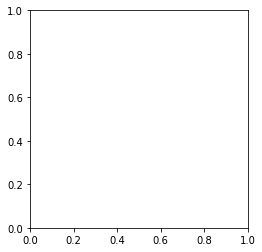

In [7]:
imim=cv2.imread("/home/dl1/src/P1/dataset/val/images/p1026i020.jpg")
plt.imshow(imim)

In [44]:
SWL(imim,8,"D")

Sliding Done


In [48]:
while True :
    for i in range(64):
        for k in range(64):
            im_input=Sliced[k][np.newaxis, np.newaxis :, :]
            img = im_input.transpose( (0,3,1,2) )
            net.blobs['data'].data[k][...] = img
        
        output=net.forward()
        result = np.array(cv2.imread(image))
        for j in range(64):
            a = net.blobs["fc2"].data[j][0]
            b = net.blobs["fc2"].data[j][1]
            c = net.blobs["fc2"].data[j][2]
            if b>a and b>c:
                Masking(result,j,"B")
            elif c>a and c>b:
                Masking(result,j,"M")
        for i in range(512):
            for j in range(512):
                if ROI[i][j][0] >0:
                    result[i][j][1]=255
    

201601


In [ ]:
    for i in range(64):
        im_input=Sliced[i][np.newaxis, np.newaxis :, :]
        img = im_input.transpose( (0,3,1,2) )
        net.blobs['data'].data[i][...] = img

2
